In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
from sklearn import preprocessing
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from statistics import mean
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [3]:
def show_plot(time, signal, window_signal):
    # Plot Signal
    plt.ylabel("Signal")
    plt.xlabel("Time [s]")
    plt.title("Plot of Signal Data")
    plt.plot(time, signal)
    plt.show()
    # Plot Windowed Data
    plt.ylabel("Windowed Signal")
    plt.xlabel("Time [s]")
    plt.title("Plot of Windowed Signal (Hanning Window)")
    plt.plot(t, window_signal)
    plt.show()

In [4]:
def generate_signal(path):
    df = pd.read_csv(path, sep='\t', names = ['Sensor 1', 'Sensor 2'])
    signal = np.sin(df['Sensor 1'] + df['Sensor 2'])
    signal = np.asarray(signal)
    return signal

In [5]:
def amplitude_peaks(path,sample_frequency):
    amp1 = []
    amp2 = []

    for file in os.listdir(path):
        x = generate_signal(path+file)

        num_samples = x.size
        num_half = num_samples//2
        f = np.fft.fftfreq(t.shape[-1])*sample_frequency # frequency information
        # Apply Hanning Window
        window = np.hamming(num_samples)
        x_window = x*window

        # Compute Fast Fourier Transform
        fft_window = np.fft.fft(x_window)       # complex spectrum
        fft_window_abs = np.abs(fft_window)     # amplitude spectrum

        # Get amplitude peaks
        peaks_index, properties = find_peaks(fft_window_abs[:num_half] / num_samples, height=0.001)

        amp_list = properties['peak_heights'].tolist()
        freq_list = peaks_index.tolist()

        largest_amp = max(amp_list)
        index1 = amp_list.index(largest_amp)
        largest_freq =  freq_list[index1]

        amp_list.remove(largest_amp)
        freq_list.remove(largest_freq)

        second_largest_amp = max(amp_list)
        index2 = amp_list.index(second_largest_amp)
        second_largest_freq =  freq_list[index2]

        amp1.append(largest_amp)
        amp2.append(second_largest_amp)
        
    show_plot(t,x,x_window)
        
    return {'amplitude1': amp1, 'amplitude2': amp2}

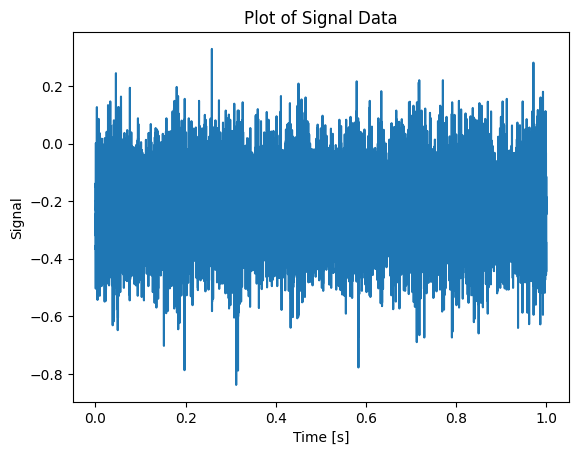

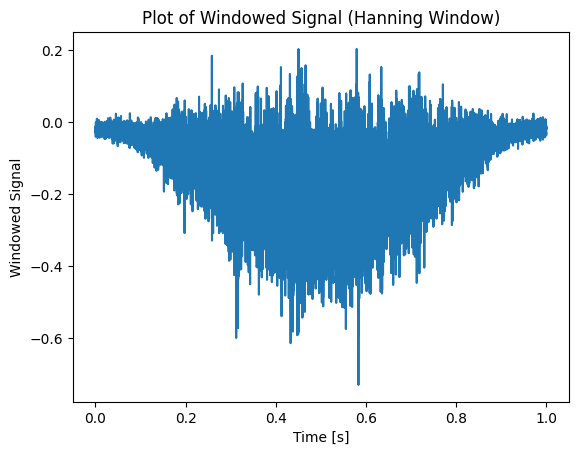

In [6]:
directory = "../../dsia-task3/task3_dataset/"
folderpath = directory + 'vibrationdata/'
targetfile = pd.read_csv(directory + 'product_quality_log.csv')

# Define Signal with two components
sample_frequency = 20480 # Hz
signal_timewindow = 1 # seconds
# Generate Signal Data
t = np.linspace(0, signal_timewindow, round(signal_timewindow*sample_frequency))

# Feature extraction - get amplitude peak values using FFT
lb = preprocessing.LabelBinarizer()
(X,y) = ((pd.DataFrame(amplitude_peaks(folderpath,sample_frequency)),lb.fit_transform(targetfile['quality'])))

target_names = list(dict.fromkeys(targetfile['quality']))

Mean f1: 0.007
Mean recall: 0.004
Mean precision: 0.033
Average Score: 0.9406182304977484
              precision    recall  f1-score   support

          OK       0.95      1.00      0.97       517
         nOK       1.00      0.07      0.12        30

    accuracy                           0.95       547
   macro avg       0.97      0.53      0.55       547
weighted avg       0.95      0.95      0.93       547



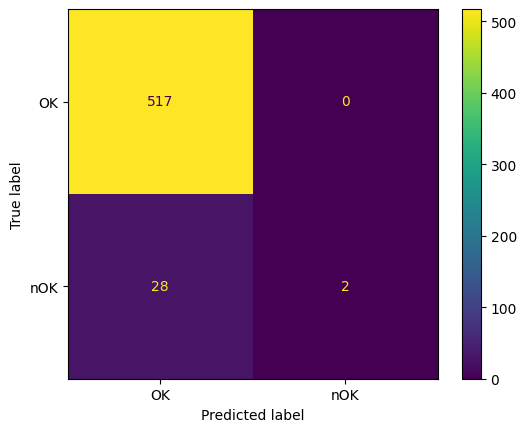

In [7]:
# ******************* Unbalanced Data **************************
#Build SRF model
SRF = RandomForestClassifier(n_estimators=150, random_state=0)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SRF model
scores = cross_validate(SRF, X, y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

scores_acc = cross_val_score(SRF, X,y, cv=cv, scoring='accuracy')
print("Average Score: {}".format(np.mean(scores_acc)))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
#Train SRF
SRF.fit(X_train, y_train)
#SRF prediction result
y_test_pred = SRF.predict(X_test)

#Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=target_names).plot()
print(classification_report(y_test, y_test_pred, target_names=target_names))

Mean f1: 0.806
Mean recall: 0.834
Mean precision: 0.780
Average Score: 0.7992272193550148
              precision    recall  f1-score   support

          OK       1.00      0.91      0.95       517
         nOK       0.39      0.97      0.55        30

    accuracy                           0.91       547
   macro avg       0.69      0.94      0.75       547
weighted avg       0.96      0.91      0.93       547



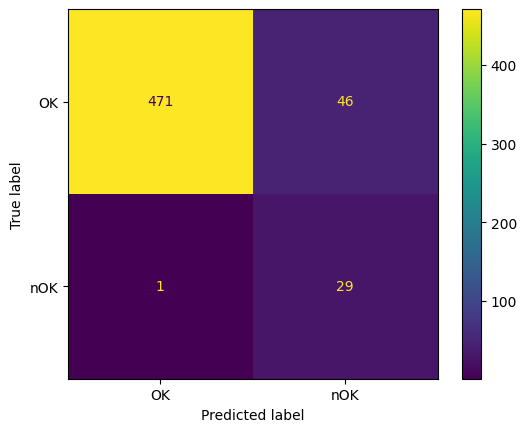

In [8]:
from imblearn.over_sampling import SMOTE
# ******************* Balanced Data **************************
#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.33, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

scores_acc = cross_val_score(SMOTE_SRF, over_X,over_y, cv=cv, scoring='accuracy')
print("Average Score: {}".format(np.mean(scores_acc)))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
#Train SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SRF prediction result
y_test_pred = SMOTE_SRF.predict(X_test)

#Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=target_names).plot()
print(classification_report(y_test, y_test_pred, target_names=target_names))